In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series

import numpy as np
import matplotlib.pyplot as plt

### 设置路径

In [2]:
path_pre = '../../'
path_original_dataset = path_pre + 'original-dataset/'
path_intermediate_dataset = path_pre + 'intermediate-dataset/'

### 加载 train.csv

In [3]:
train_df = pd.read_hdf(path_intermediate_dataset + 'train.h5')
train_df.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator
111,0,170000,NaN,2522,1855022,6539,1,1.0
90,0,170000,NaN,1004,2279109,5414,1,1.0
5,0,170000,NaN,3293,1177829,3347,1,1.0
101,0,170000,NaN,1259,2277789,3347,1,1.0
34,0,170000,NaN,4757,496624,2058,1,1.0


### 提取转化回流时间特征，即deltaTime

In [4]:
def to_minute(df, column):
    indexer = ~df[column].isnull()
    day = np.floor(df.loc[indexer, column] / 10000)
    hour = np.floor(df.loc[indexer, column] / 100) % 100
    minute = df.loc[indexer, column] % 100
    df.loc[indexer, column + '_min'] = day * 24 * 60 + hour * 60 + minute

In [5]:
to_minute(train_df, 'clickTime')
to_minute(train_df, 'conversionTime')
train_df.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,clickTime_min,conversionTime_min
111,0,170000,NaN,2522,1855022,6539,1,1.0,24480.0,NaN
90,0,170000,NaN,1004,2279109,5414,1,1.0,24480.0,NaN
5,0,170000,NaN,3293,1177829,3347,1,1.0,24480.0,NaN
101,0,170000,NaN,1259,2277789,3347,1,1.0,24480.0,NaN
34,0,170000,NaN,4757,496624,2058,1,1.0,24480.0,NaN


In [6]:
train_df['deltaTime_min'] = train_df['conversionTime_min'] - train_df['clickTime_min']
train_df.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,clickTime_min,conversionTime_min,deltaTime_min
111,0,170000,NaN,2522,1855022,6539,1,1.0,24480.0,NaN,NaN
90,0,170000,NaN,1004,2279109,5414,1,1.0,24480.0,NaN,NaN
5,0,170000,NaN,3293,1177829,3347,1,1.0,24480.0,NaN,NaN
101,0,170000,NaN,1259,2277789,3347,1,1.0,24480.0,NaN,NaN
34,0,170000,NaN,4757,496624,2058,1,1.0,24480.0,NaN,NaN


In [7]:
distribution_deltaTime = train_df['deltaTime_min'].value_counts()
distribution_deltaTime.sort_index(inplace=True)

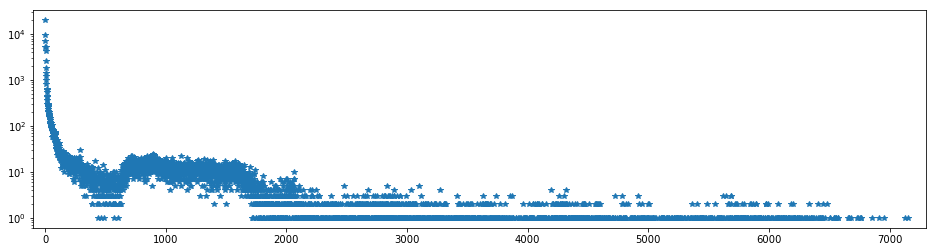

In [8]:
distribution_deltaTime.plot(figsize=(16,4), style='*', logy=True)
plt.xlim([-100, 7300])
plt.show()

In [9]:
distribution_deltaTime_df = DataFrame(distribution_deltaTime)
distribution_deltaTime_df.reset_index(inplace=True)
distribution_deltaTime_df.columns = ['deltaTime_min', 'num']
distribution_deltaTime_df.head()

,deltaTime_min,num
0,0.0,7198
1,1.0,19998
2,2.0,9773
3,3.0,5247
4,4.0,4313


In [10]:
distribution_deltaTime_df['ratio'] = distribution_deltaTime_df['num'] / distribution_deltaTime_df['num'].sum()
distribution_deltaTime_df['ratio_cumsum'] = distribution_deltaTime_df['ratio'].cumsum()
distribution_deltaTime_df.head()

,deltaTime_min,num,ratio,ratio_cumsum
0,0.0,7198,0.077180,0.077180
1,1.0,19998,0.214428,0.291609
2,2.0,9773,0.104791,0.396399
3,3.0,5247,0.056261,0.452660
4,4.0,4313,0.046246,0.498906


In [11]:
distribution_deltaTime_df.tail()

,deltaTime_min,num,ratio,ratio_cumsum
3558,6854.0,1,0.000011,0.999957
3559,6908.0,1,0.000011,0.999968
3560,6953.0,1,0.000011,0.999979
3561,7130.0,1,0.000011,0.999989
3562,7153.0,1,0.000011,1.000000


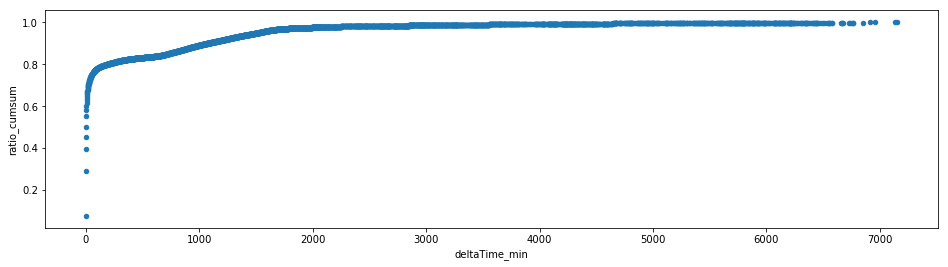

In [12]:
distribution_deltaTime_df.plot(x='deltaTime_min', y='ratio_cumsum', figsize=(16,4), kind='scatter')
plt.show()

### 提取 confidence 表

In [13]:
distribution_deltaTime_df['deltaTime_min'] = distribution_deltaTime_df['deltaTime_min'].astype(int, copy=False)
distribution_deltaTime_df.set_index('deltaTime_min', inplace=True)

In [14]:
new_index = list(range(distribution_deltaTime_df.index.max() + 1))
confidence = distribution_deltaTime_df['ratio_cumsum'].reindex(new_index, method='ffill')
confidence.rename('confidence', inplace=True)
confidence.index.name = 'delta_deadline_min'
confidence.head()

delta_deadline_min
0    0.077180
1    0.291609
2    0.396399
3    0.452660
4    0.498906
Name: confidence, dtype: float64

In [15]:
confidence_df = confidence.reset_index()
confidence_df.head()

,delta_deadline_min,confidence
0,0,0.077180
1,1,0.291609
2,2,0.396399
3,3,0.452660
4,4,0.498906


如何从这个表中获取样本的置信度  
1. testset_ol 中样本的置信度都为1
2. 所有正样本的置信度都为1
3. 训练集中负样本的置信度与距302400的分钟时间差有关系。5天以上的样本置信度为1；5天以内的，根据距310000的分钟时间差deltaTime_min在上表中查询。首先找到第一个比它小的deltaTime_min，然后以它的ratio_cumsum作为样本的置信度。

### 构造置信度特征 Confidence

In [16]:
train_df['delta_deadline_min'] = 30 * 24 * 60 + 23 * 60 + 59 - train_df['clickTime_min']
train_df.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,clickTime_min,conversionTime_min,deltaTime_min,delta_deadline_min
111,0,170000,NaN,2522,1855022,6539,1,1.0,24480.0,NaN,NaN,20159.0
90,0,170000,NaN,1004,2279109,5414,1,1.0,24480.0,NaN,NaN,20159.0
5,0,170000,NaN,3293,1177829,3347,1,1.0,24480.0,NaN,NaN,20159.0
101,0,170000,NaN,1259,2277789,3347,1,1.0,24480.0,NaN,NaN,20159.0
34,0,170000,NaN,4757,496624,2058,1,1.0,24480.0,NaN,NaN,20159.0


In [17]:
train_df = train_df.merge(confidence_df, how='left', on='delta_deadline_min')

In [18]:
train_df.loc[train_df['delta_deadline_min'] == 0].head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,clickTime_min,conversionTime_min,deltaTime_min,delta_deadline_min,confidence
3749319,0,302359,NaN,6072,587482,788,1,3.0,44639.0,NaN,NaN,0.0,0.07718
3749320,0,302359,NaN,1617,111120,6936,1,2.0,44639.0,NaN,NaN,0.0,0.07718
3749321,0,302359,NaN,5187,1752993,7434,3,1.0,44639.0,NaN,NaN,0.0,0.07718
3749322,0,302359,NaN,4465,19488,7511,1,2.0,44639.0,NaN,NaN,0.0,0.07718
3749323,0,302359,NaN,3497,51953,1385,1,1.0,44639.0,NaN,NaN,0.0,0.07718


In [19]:
train_df.loc[train_df['delta_deadline_min'] == 1].head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,clickTime_min,conversionTime_min,deltaTime_min,delta_deadline_min,confidence
3749132,0,302358,NaN,3871,1307119,5886,1,1.0,44638.0,NaN,NaN,1.0,0.291609
3749133,0,302358,NaN,4494,1549316,5745,1,2.0,44638.0,NaN,NaN,1.0,0.291609
3749134,0,302358,NaN,4432,2516828,5637,1,1.0,44638.0,NaN,NaN,1.0,0.291609
3749135,0,302358,NaN,3305,1715660,6727,1,3.0,44638.0,NaN,NaN,1.0,0.291609
3749136,0,302358,NaN,3885,802404,4856,1,1.0,44638.0,NaN,NaN,1.0,0.291609


In [20]:
train_df.loc[train_df['delta_deadline_min'] == 2].head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,clickTime_min,conversionTime_min,deltaTime_min,delta_deadline_min,confidence
3748929,0,302357,NaN,6247,1332302,3365,1,3.0,44637.0,NaN,NaN,2.0,0.396399
3748930,0,302357,NaN,1143,422392,1180,1,1.0,44637.0,NaN,NaN,2.0,0.396399
3748931,0,302357,NaN,5187,1076135,2188,1,1.0,44637.0,NaN,NaN,2.0,0.396399
3748932,0,302357,NaN,863,1386853,6315,2,1.0,44637.0,NaN,NaN,2.0,0.396399
3748933,0,302357,NaN,2122,1169898,7297,0,3.0,44637.0,NaN,NaN,2.0,0.396399


In [21]:
# 所有正样本的置信度都为1, 5天以上的样本置信度为1
indexer = (train_df['label'] == 1) | (train_df['delta_deadline_min'] > 7153)
train_df.loc[indexer, 'confidence'] = 1

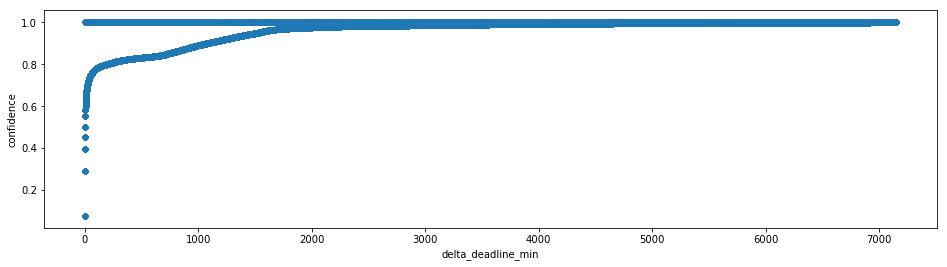

In [22]:
train_df.loc[train_df['delta_deadline_min'] <= 7153].plot(x='delta_deadline_min', y='confidence', figsize=(16,4), kind='scatter')
plt.show()

In [23]:
train_df.loc[train_df['confidence'].isnull()]

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,clickTime_min,conversionTime_min,deltaTime_min,delta_deadline_min,confidence
